# Install dependecies

In [ ]:
!apt-get update && apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,852 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,375 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/unive

In [ ]:
!pip install shimmy

In [ ]:
import torch
from gym import spaces
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv,VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import gym

import torch.nn as nn
import torch

import matplotlib.pyplot as plt

from tqdm import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Env

In [ ]:
class Game2048Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(Game2048Env, self).__init__()
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=2**16, shape=(1, 4, 4), dtype=np.int32)
        self.grid = self.init_grid()
        self.episode_reward = 0

    def init_grid(self):
        grid = np.zeros((4, 4), dtype=np.int32)
        for _ in range(2):
            self.add_new_tile(grid)
        return grid

    def add_new_tile(self, grid):
        empty_cells = list(zip(*np.where(grid == 0)))
        if empty_cells:
            x, y = empty_cells[np.random.randint(0, len(empty_cells))]
            grid[x, y] = 2 if np.random.random() < 0.9 else 4

    def reset(self):
        self.grid = self.init_grid()
        self.episode_reward = 0
        return self.grid[np.newaxis, :, :]  # Add channel dimension

    def step(self, action):
        if action not in [0, 1, 2, 3]:
            raise ValueError("Invalid Action")

        old_grid = self.grid.copy()
        self.move(action)
        if not np.array_equal(old_grid, self.grid):
            self.add_new_tile(self.grid)

        reward = self.calculate_reward()
        self.episode_reward += reward
        terminated = self.check_if_game_over()
        truncated = False
        info = {"episode_reward": self.episode_reward} if terminated else {}

        return self.grid[np.newaxis, :, :], reward, terminated, truncated, info  # Add channel dimension

    def move(self, action):
        if action == 0:  # up
            self.grid = self.move_up(self.grid)
        elif action == 1:  # down
            self.grid = self.move_down(self.grid)
        elif action == 2:  # left
            self.grid = self.move_left(self.grid)
        elif action == 3:  # right
            self.grid = self.move_right(self.grid)

    def move_up(self, grid):
        return np.array([self.collapse_column(grid[:, i]) for i in range(4)]).T

    def move_down(self, grid):
        return np.array([self.collapse_column(grid[:, i][::-1])[::-1] for i in range(4)]).T

    def move_left(self, grid):
        return np.array([self.collapse_column(grid[i, :]) for i in range(4)])

    def move_right(self, grid):
        return np.array([self.collapse_column(grid[i, :][::-1])[::-1] for i in range(4)])

    def collapse_column(self, col):
        col = col[col != 0]
        new_col = []
        skip = False
        for i in range(len(col)):
            if skip:
                skip = False
                continue
            if i + 1 < len(col) and col[i] == col[i + 1]:
                new_col.append(col[i] * 2)
                skip = True
            else:
                new_col.append(col[i])
        return np.array(new_col + [0] * (4 - len(new_col)))

    def calculate_reward(self):
        return np.max(self.grid)

    def check_if_game_over(self):
        if not np.any(self.grid == 0):
            for i in range(4):
                for j in range(4):
                    if i + 1 < 4 and self.grid[i, j] == self.grid[i + 1, j]:
                        return False
                    if j + 1 < 4 and self.grid[i, j] == self.grid[i, j + 1]:
                        return False
            return True
        return False

    def render(self, mode='human', close=False):
        print(self.grid)

# Reward Logging

In [ ]:
# Updated RewardLoggingCallback
class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.current_episode_reward = 0

    def _on_step(self) -> bool:
        self.current_episode_reward += self.locals['rewards'][0]
        if self.locals['dones'][0]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0
        return True

# Train

## Model 1 MLP

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_reward=True)

# Define custom policy architecture
policy_kwargs = dict(
    net_arch=[dict(pi=[64, 64], vf=[128, 128])]
)

# Create the PPO model with the custom MlpPolicy and adjusted hyperparameters
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs, learning_rate=0.00001, n_steps=2048, batch_size=1024, n_epochs=10, clip_range=0.2, ent_coef=0.01, vf_coef=0.5, max_grad_norm=0.5, verbose=1)

reward_logging_callback = RewardLoggingCallback()

# Train the model
model.learn(total_timesteps=800000, callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_mlp")

# Load the model
model = PPO.load("ppo_2048_mlp", env=env)

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards

Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 478          |
|    total_timesteps      | 233472       |
| train/                  |              |
|    approx_kl            | 2.225861e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.332        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.0391       |
|    n_updates            | 1130         |
|    policy_gradient_loss | -3.52e-05    |
|    value_loss           | 0.11         |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 487           |
|    iterations           | 115           |
|    time_elapsed         | 482           |
|    total_timesteps      | 235520        |
| train/                  |               |
|    approx_kl            | 2.7872738e-

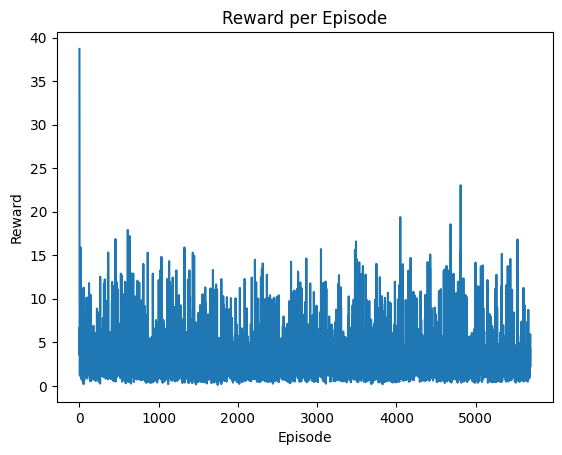

In [ ]:
# Plot the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

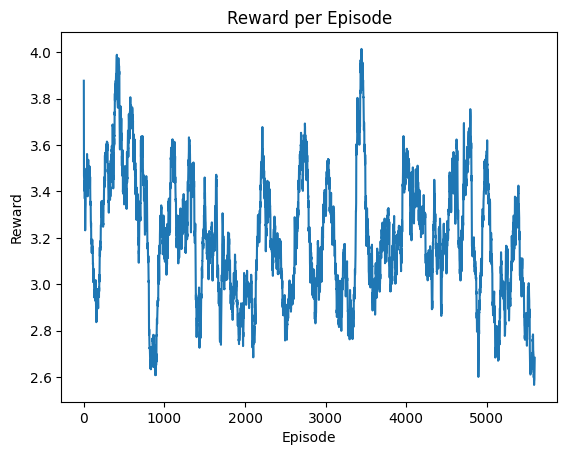

In [ ]:
# Plot the moving average of the rewards
moving_average = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
plt.plot(moving_average)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

## Model 2 CNN

In [ ]:
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Calculate the shape of the flattened output from the CNN
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations):
        return self.linear(self.cnn(observations))

class CustomCnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=CustomCNN)

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(CustomCnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1000000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_cnn")

# Load the model
model = PPO.load("ppo_2048_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1433        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.009975968 |
|    clip_fraction        | 0.0697      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.495      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03e+06    |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00521    |
|    value_loss           | 2.01e+06    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 302          |
|    iterations           | 213          |
|    time_elapsed         | 1440         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0033931814 |
|    clip_fractio

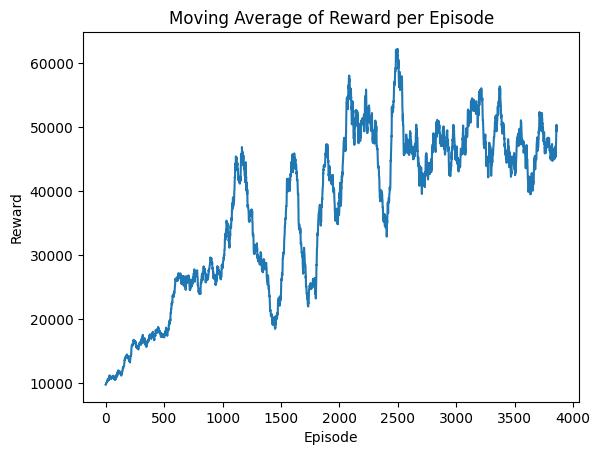

In [ ]:
# Plot the moving average of episode_rewards
plt.plot(np.convolve(episode_rewards, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Moving Average of Reward per Episode')
plt.show()

## Model 3 CNN (bigger architecture)

In [ ]:
import torch
import torch.nn as nn
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomArchitectureCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=256):
        super(CustomArchitectureCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]

        self.conv1_layer1 = nn.Conv2d(n_input_channels, 16, kernel_size=(1, 2), stride=1, padding=0)
        self.conv2_layer1 = nn.Conv2d(n_input_channels, 16, kernel_size=(2, 1), stride=1, padding=0)

        self.conv1_layer2 = nn.Conv2d(16, 128, kernel_size=(1, 2), stride=1, padding=0)
        self.conv2_layer2 = nn.Conv2d(16, 128, kernel_size=(2, 1), stride=1, padding=0)

        self.conv1_layer3 = nn.Conv2d(128, 128, kernel_size=(1, 2), stride=1, padding=0)
        self.conv2_layer3 = nn.Conv2d(128, 128, kernel_size=(2, 1), stride=1, padding=0)

        self.flatten = nn.Flatten()

        with torch.no_grad():
            n_flatten = self._get_flattened_size(observation_space)

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 256),
            nn.ReLU()
        )

    def _get_flattened_size(self, observation_space):
        sample_input = torch.as_tensor(observation_space.sample()[None]).float()
        x1 = self.conv1_layer1(sample_input)
        x2 = self.conv2_layer1(sample_input)
        x1 = self.conv1_layer2(x1)
        x2 = self.conv2_layer2(x2)
        x1 = self.conv1_layer3(x1)
        x2 = self.conv2_layer3(x2)
        x1 = nn.functional.adaptive_avg_pool2d(x1, (1, 1))
        x2 = nn.functional.adaptive_avg_pool2d(x2, (1, 1))
        x = torch.cat((x1, x2), dim=1)
        x = self.flatten(x)
        return x.shape[1]

    def forward(self, observations):
        x1 = self.conv1_layer1(observations)
        x2 = self.conv2_layer1(observations)
        x1 = self.conv1_layer2(x1)
        x2 = self.conv2_layer2(x2)
        x1 = self.conv1_layer3(x1)
        x2 = self.conv2_layer3(x2)
        x1 = nn.functional.adaptive_avg_pool2d(x1, (1, 1))
        x2 = nn.functional.adaptive_avg_pool2d(x2, (1, 1))
        x = torch.cat((x1, x2), dim=1)
        x = self.flatten(x)
        return self.linear(x)

class CustomCnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomCnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=CustomArchitectureCNN)

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(CustomCnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1000000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_cnn")

# Load the model
model = PPO.load("ppo_2048_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1433        |
|    total_timesteps      | 434176      |
| train/                  |             |
|    approx_kl            | 0.009975968 |
|    clip_fraction        | 0.0697      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.495      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 1.03e+06    |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.00521    |
|    value_loss           | 2.01e+06    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 302          |
|    iterations           | 213          |
|    time_elapsed         | 1440         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 0.0033931814 |
|    clip_fractio

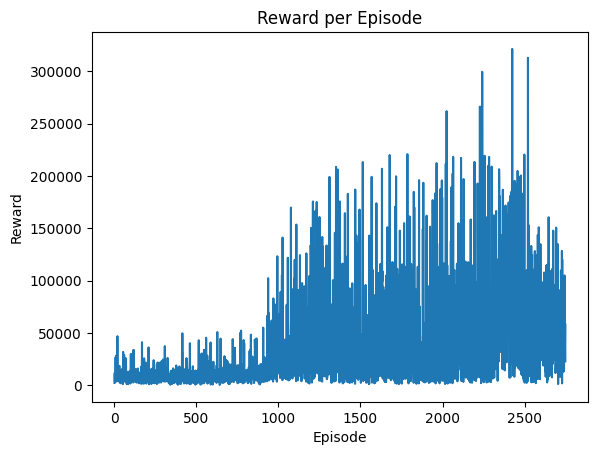

In [ ]:
# Plot the rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

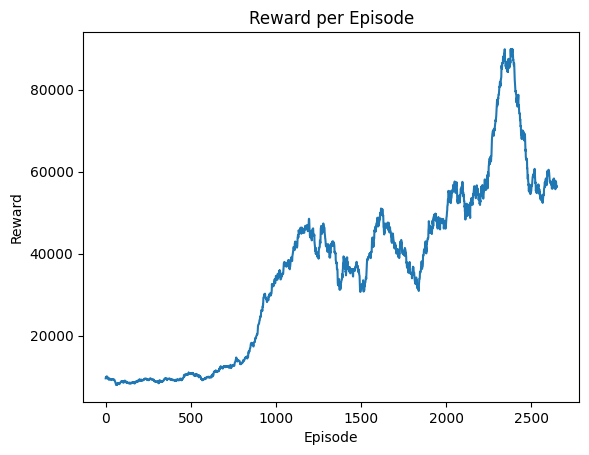

In [ ]:
# Plot the moving average of the rewards
moving_average = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')
plt.plot(moving_average)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()

## Model 4 CNN (bigger)

In [ ]:
class BiggerCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=1024):
        super(BiggerCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the shape of the flattened output from the CNN
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations):
        return self.linear(self.cnn(observations))

class BiggerCnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(BiggerCnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=BiggerCNN)

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(BiggerCnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1000000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_model4_cnn")

# Load the model
model = PPO.load("ppo_2048_model4_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1509         |
|    total_timesteps      | 434176       |
| train/                  |              |
|    approx_kl            | 0.0074544055 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 8.73e+05     |
|    n_updates            | 2110         |
|    policy_gradient_loss | 0.00129      |
|    value_loss           | 1.77e+06     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 287         |
|    iterations           | 213         |
|    time_elapsed         | 1516        |
|    total_timesteps      | 436224      |
| train/                  |             |
|    approx_kl            | 0.015947405 |
|    clip_f

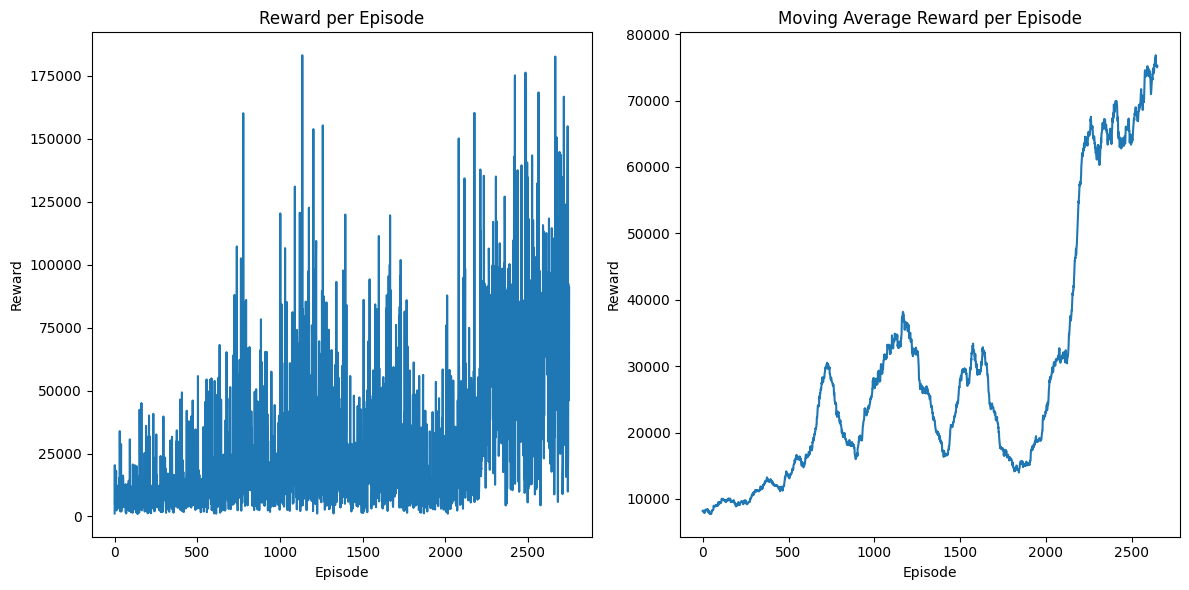

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the moving average
moving_average = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the rewards on the first subplot
axs[0].plot(episode_rewards)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward per Episode')

# Plot the moving average of the rewards on the second subplot
axs[1].plot(moving_average)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Reward')
axs[1].set_title('Moving Average Reward per Episode')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Model 5 CNN (less convolution, more fully connected)

In [ ]:
import torch
import torch.nn as nn
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class BiggerCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=1024):
        super(BiggerCNN, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Calculate the shape of the flattened output from the CNN
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        return self.linear(self.cnn(observations))

class BiggerCnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(BiggerCnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=BiggerCNN)

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_reward=True)

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(BiggerCnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1000000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_cnn_model_5_not_vecnorm")

# Load the model
model = PPO.load("ppo_2048_cnn_model_5_not_vecnorm")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 1537          |
|    total_timesteps      | 434176        |
| train/                  |               |
|    approx_kl            | 0.00024916587 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.409        |
|    explained_variance   | 1.19e-07      |
|    learning_rate        | 0.0003        |
|    loss                 | 2.26e+06      |
|    n_updates            | 2110          |
|    policy_gradient_loss | -0.000167     |
|    value_loss           | 4.35e+06      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 282          |
|    iterations           | 213          |
|    time_elapsed         | 1544         |
|    total_timesteps      | 436224       |
| train/                  |              |
|    approx_kl            | 4.86

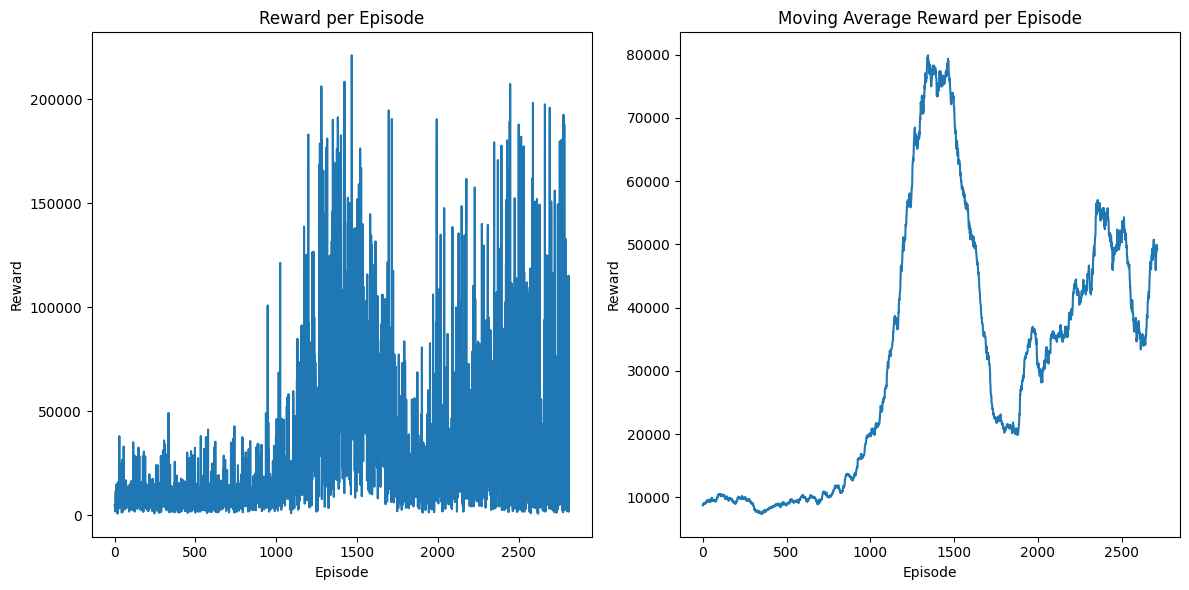

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the moving average
moving_average = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the rewards on the first subplot
axs[0].plot(episode_rewards)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward per Episode')

# Plot the moving average of the rewards on the second subplot
axs[1].plot(moving_average)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Reward')
axs[1].set_title('Moving Average Reward per Episode')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Model 6

In [ ]:
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticCnnPolicy

class model6cnn(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=512):
        super(model6cnn, self).__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )

        # Calculate the shape of the flattened output from the CNN
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 256),
            nn.ReLU(),
            nn.Linear(256, features_dim),
            nn.ReLU()
        )

    def forward(self, observations):
        return self.linear(self.cnn(observations))

class model6cnnPolicy(ActorCriticCnnPolicy):
    def __init__(self, *args, **kwargs):
        super(model6cnnPolicy, self).__init__(*args, **kwargs, features_extractor_class=model6cnn)

In [ ]:
# Register the environment
gym.envs.registration.register(
    id='Game2048-v0',
    entry_point=Game2048Env,
    max_episode_steps=1000,
)

# Create the environment
env = gym.make('Game2048-v0')
env = DummyVecEnv([lambda: env])

# Create the callback
reward_logging_callback = RewardLoggingCallback()

# Create the PPO model with the custom CNN policy
model = PPO(model6cnnPolicy, env, verbose=1, device='cuda')  # Change 'auto' to 'cuda' to use GPU

# Train the model
model.learn(total_timesteps=1500000,callback=reward_logging_callback)

# Save the model
model.save("ppo_2048_model6_cnn")

# Load the model
model = PPO.load("ppo_2048_model6_cnn")

# Save the rewards for plotting
episode_rewards = reward_logging_callback.episode_rewards


Streaming output truncated to the last 5000 lines.
|    time_elapsed         | 3180        |
|    total_timesteps      | 933888      |
| train/                  |             |
|    approx_kl            | 0.011433946 |
|    clip_fraction        | 0.0911      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.528      |
|    explained_variance   | 0.0574      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.72e+05    |
|    n_updates            | 4550        |
|    policy_gradient_loss | 0.00433     |
|    value_loss           | 9.39e+05    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 293          |
|    iterations           | 457          |
|    time_elapsed         | 3187         |
|    total_timesteps      | 935936       |
| train/                  |              |
|    approx_kl            | 0.0057421685 |
|    clip_fractio

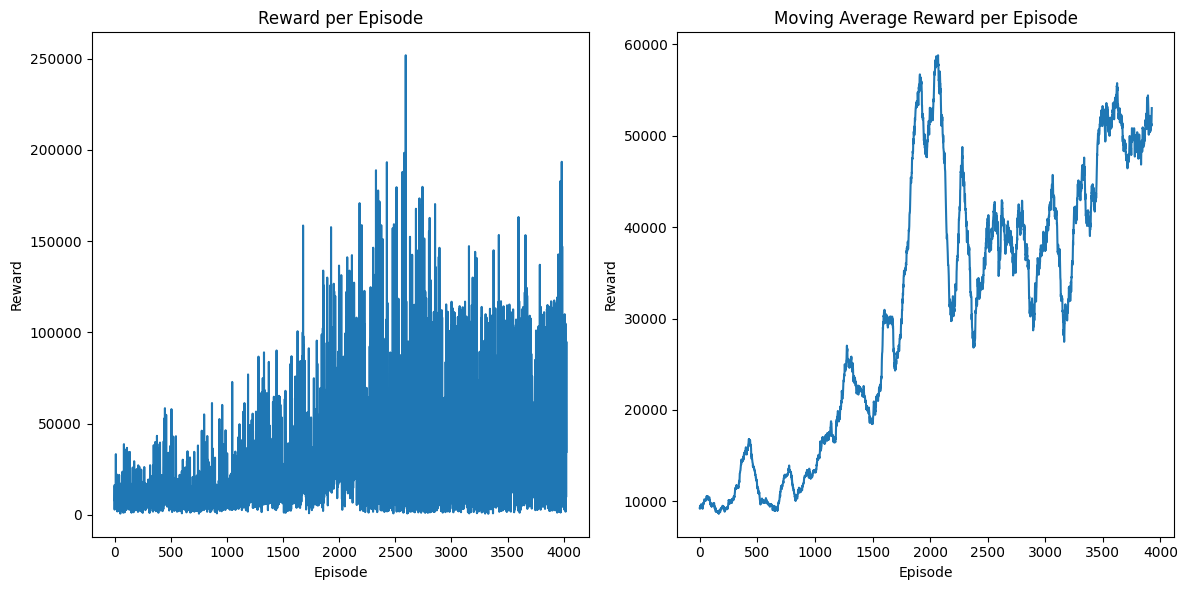

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the moving average
moving_average = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the rewards on the first subplot
axs[0].plot(episode_rewards)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward per Episode')

# Plot the moving average of the rewards on the second subplot
axs[1].plot(moving_average)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Reward')
axs[1].set_title('Moving Average Reward per Episode')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Load and test model

In [ ]:
!gdown 1eiFZKvbrnGbvZP2qDLJ4DWWTJzol4ElI

Downloading...
From: https://drive.google.com/uc?id=1eiFZKvbrnGbvZP2qDLJ4DWWTJzol4ElI
To: /content/ppo_2048_model2_cnn.zip
100% 1.55M/1.55M [00:00<00:00, 153MB/s]


In [ ]:
model = PPO.load("/content/ppo_2048_model2_cnn.zip")
env = Game2048Env()

- Run model

In [ ]:
results = []
for _ in tqdm(range(100)):
  obs = env.reset()
  for i in range(1000):
      action, _states = model.predict(obs)
      obs, rewards, dones, truncated, info = env.step(action)

      if dones:
        break

  results.append(np.max(env.grid))


100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


In [ ]:
from collections import Counter

counter_model = dict(Counter(results))
counter_model = {k: v / sum(counter_model.values()) for k, v in counter_model.items()}
counter_model = sorted(list(counter_model.items()),key = lambda x:x[0])
counter_model = counter_model[1:]


In [ ]:
counter_model

[(32, 0.05), (64, 0.14), (128, 0.51), (256, 0.26), (512, 0.03)]

In [ ]:
s,p=zip(*counter_model)

- Run control

In [ ]:
results_rand = []
for _ in tqdm(range(200)):
  obs = env.reset()
  for i in range(1000):
      action = np.random.randint(4)
      obs, rewards, dones, truncated, info = env.step(action)

      if dones:
        break

  results_rand.append(np.max(env.grid))


100%|██████████| 200/200 [00:02<00:00, 80.94it/s]


In [ ]:
counter_rand = dict(Counter(results_rand))
# Normalize counter_rand by frequency
counter_rand = {k: v / sum(counter_rand.values()) for k, v in counter_rand.items() if k in s}
counter_rand = sorted(list(counter_rand.items()),key = lambda x:x[0])

counter_rand

[(32, 0.065), (64, 0.38), (128, 0.475), (256, 0.07)]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (4,).

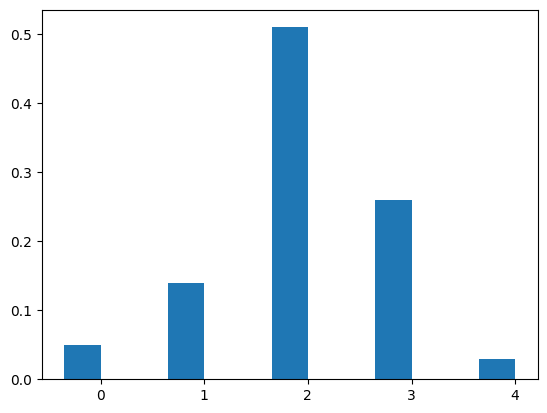

In [ ]:
import matplotlib.pyplot as plt

# Example counters for demonstration
# Get the values and counts for both counters
vals_model, count_model = zip(*counter_model)
vals_rand, count_rand = zip(*counter_rand)

# Create the bar chart
x = list(range(len(vals_model)))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in x], count_model, width, label='Random')
rects2 = ax.bar([i + width/2 for i in x], count_rand, width, label='Model')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(vals_model)
ax.legend()
ax.set_ylabel('Frequency')
ax.set_xlabel('Max Score')
ax.set_title('Comparison of Model and Random Results')

# Show the plot
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (5,).

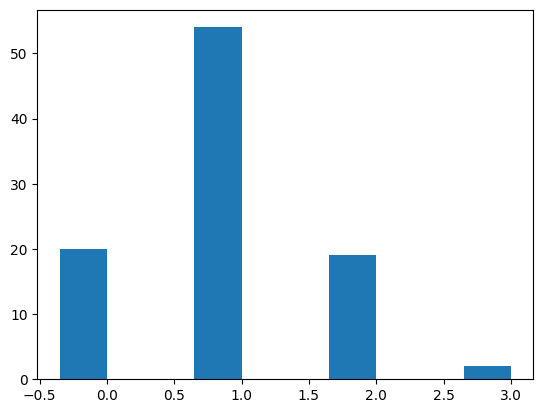

In [ ]:
jimport matplotlib.pyplot as plt

# Example counters for demonstration
# Get the values and counts for both counters
vals_model, count_model = zip(*counter_model)
vals_rand, count_rand = zip(*counter_rand)

# Create the bar chart
x = list(range(len(vals_model)))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in x], count_model, width, label='Random')
rects2 = ax.bar([i + width/2 for i in x], count_rand, width, label='Model')

# Add labels and title
ax.set_xticks(x)
ax.set_xticklabels(vals_model)
ax.legend()
ax.set_ylabel('Frequency')
ax.set_xlabel('Max Score')
ax.set_title('Comparison of Model and Random Results')

# Show the plot
plt.show()